In [1]:
from fastai.vision import *

In [5]:
# workspace path
path = Path('.')
(path/'dataset').ls()

[PosixPath('dataset/models'),
 PosixPath('dataset/best_27.pkl'),
 PosixPath('dataset/test.csv'),
 PosixPath('dataset/Train Images'),
 PosixPath('dataset/export.pkl'),
 PosixPath('dataset/train.csv'),
 PosixPath('dataset/Test Images')]

In [3]:
# quick glimse of dataset
df =  pd.read_csv(path/'dataset/train.csv')
df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [6]:
np.random.seed(10) # fixing randomness (to get standard result everytime on training)

src = (ImageList.from_csv(path/'dataset', 'train.csv', folder='Train Images')
      .split_by_rand_pct(.25)
      .label_from_df())

In [11]:
# handling transformations on data
data = (src.transform(get_transforms(), size=(80, 60))
       .databunch().normalize(imagenet_stats))

In [12]:
data.classes, len(data.train_ds), len(data.valid_ds)

(['Attire', 'Decorationandsignage', 'Food', 'misc'], 4488, 1495)

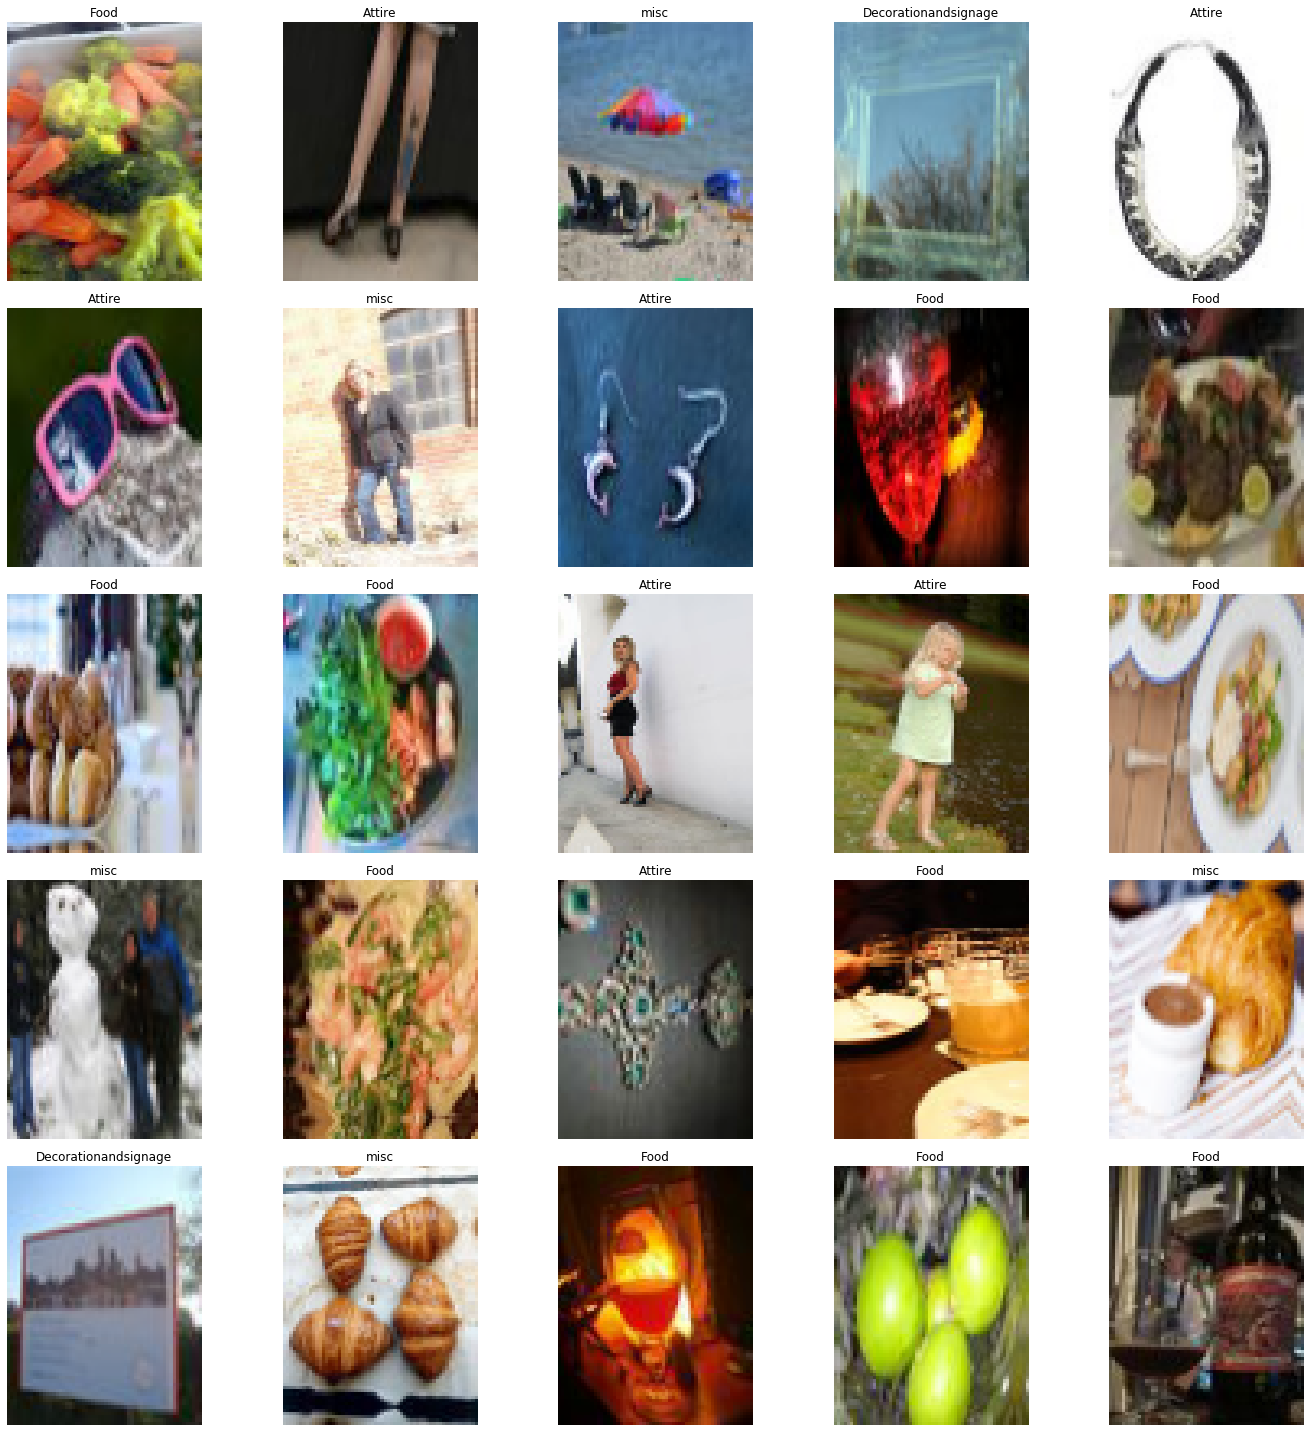

In [13]:
data.show_batch()

In [15]:
# defining classifier
learn = cnn_learner(data, models.resnet152, metrics=accuracy)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


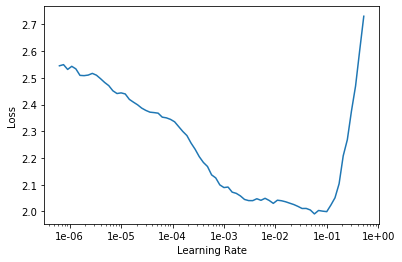

In [19]:
learn.recorder.plot()

In [20]:
lr = 3e-4

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.772706,1.097145,0.642140,00:29
1,1.464316,1.010789,0.668227,00:28
2,1.282339,0.903387,0.690970,00:29
3,1.111079,0.877821,0.682274,00:27
4,1.029465,0.860489,0.686957,00:27


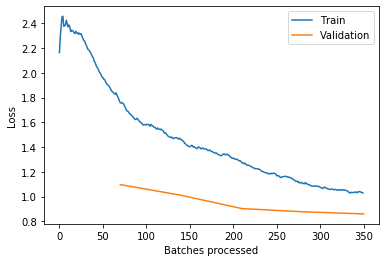

In [23]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-1-rn152')

## Interpretation

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

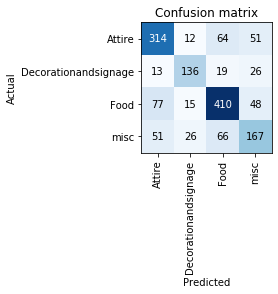

In [31]:
interp.plot_confusion_matrix()

## Fine tuning

In [32]:
learn.unfreeze()

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


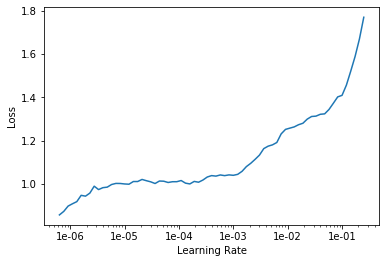

In [35]:
learn.recorder.plot()

In [36]:
new_lr = slice(5e-06, lr/5)

In [37]:
learn.fit_one_cycle(5, new_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.997294,0.829814,0.696321,00:39
1,0.928910,0.783386,0.717057,00:38
2,0.843166,0.754788,0.725084,00:39
3,0.739870,0.751123,0.719732,00:38
4,0.702830,0.749738,0.723077,00:39


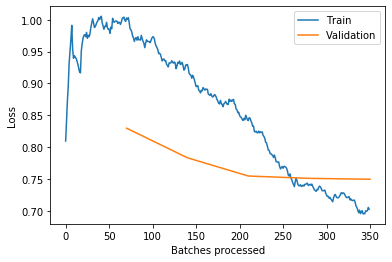

In [38]:
learn.recorder.plot_losses()

In [39]:
learn.save('stage-2-rn152')

In [41]:
learn.export(destroy=True)

this Learner object self-destroyed - it still exists, but no longer usable


## Inference

In [42]:
(path/'dataset/').ls()

[PosixPath('dataset/models'),
 PosixPath('dataset/best_27.pkl'),
 PosixPath('dataset/test.csv'),
 PosixPath('dataset/Train Images'),
 PosixPath('dataset/export.pkl'),
 PosixPath('dataset/train.csv'),
 PosixPath('dataset/Test Images')]

In [43]:
test_ds = ImageList.from_csv(path/'dataset/', 'test.csv', folder='Test Images')

In [45]:
# creating new classifier to add test data
learn = load_learner(path/'dataset/', test=test_ds)

In [52]:
# prediction on testset
pred, y = learn.get_preds(ds_type=DatasetType.Test)

In [54]:
pred[:3]

tensor([[1.8353e-01, 1.3847e-01, 6.3420e-01, 4.3788e-02],
        [3.1966e-02, 2.9825e-03, 9.3743e-01, 2.7624e-02],
        [9.5820e-04, 1.8968e-03, 9.8156e-01, 1.5589e-02]])

In [55]:
# acquiring labels
pred_label = [learn.data.classes[np.argmax(p)] for p in pred]

In [56]:
pred_label[:3]

['Food', 'Food', 'Food']

In [60]:
# acquiring filenames
fnames = [f.split('/')[-1] for f in learn.data.test_ds.items]

In [61]:
fnames[:3]

['image6245.jpg', 'image10409.jpg', 'image8692.jpg']

In [62]:
# creating new csv using pandas DF
df = pd.DataFrame({'Image':fnames, 'Class':pred_label}, columns=['Image', 'Class'])

In [63]:
df.to_csv('submission_28.csv', index=False)

In [ ]:
df2 = pd.read_csv('submission_28.csv')
df2.hea